![head.png](figures/head.jpg)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

In [95]:
# Packages used in this notebook
import requests
from bs4 import BeautifulSoup
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
import pandas as pd
import configparser
import openai

# Update package stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Web scraping

[Web scraping](https://en.wikipedia.org/wiki/Web_scraping) refers to the **extraction of data from websites**. It's a useful technique for building datasets, especially in situations where data isn't easily accessible via APIs or other direct methods. Before we begin, it's important to mention the ethical and legal considerations associated with web scraping. Always respect the rules of the site you're scraping, including the website's robots.txt file and terms of service.

Python provides several libraries to facilitate web scraping, such as [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/), [Scrapy](https://scrapy.org/), and [Requests](https://requests.readthedocs.io/en/latest/). In this class, we'll focus on using BeautifulSoup and Requests.

First, we need to send an HTTP request to the URL of the webpage you want to access. The server responds to the request by returning the HTML content of the webpage. For this task, we'll be using the requests library. The `requests.get()` function sends a **GET request** to the specified url. If the request is successful, the **status code** will be 200. You can check the status code by `response.status_code`.

Once we have accessed the HTML content, we are left with the task of parsing the data. Since most of the HTML data is nested, we cannot extract data simply through string processing (we could, but it's quite annoying). One needs a parser which can create a **nested/tree structure of the HTML data**. Let's try this out using news articles from [https://news.yahoo.com/](https://news.yahoo.com/):

In [96]:
# URL of the webpage we want to scrape data from
url = "https://www.uni-halle.de/newsarchiv.1.en.php"
# Sends a GET request to the URL to retrieve its content
response = requests.get(url)
assert response.status_code == 200
print(response.text)
# Parse results
soup = BeautifulSoup(response.text, 'html.parser')

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en">
<head>
 <title>Newsarchiv: Creating knowledge since 1502</title>
 <meta http-equiv="content-type" content="text/html;charset=ISO-8859-1" />
 <meta http-equiv="content-script-type" content="text/javascript" />
 <meta name="language" content="en" />
 <meta name="keywords" content="Informationen Uni Halle MLU Martin-Luther-Universität Halle-Wittenberg Informationen Kontakt Lehre Studium Verwaltung "/>
 <meta name="description" content="Startseite der Martin-Luther-Universität Halle-Wittenberg." />
 <meta name="robots" content="follow"/>
 <meta name="robots" content="index"/>
 <link href="/im/sod/common/css/styles.css" rel="stylesheet" type="text/css"/>
 <link rel="stylesheet" href="/im/js/highslide/highslide.css" type="text/css"/>
 <!--<link rel="shortcut icon" href="/im/sod/common/img/favicon.ico" type="image/x

Please note that some, more complex and dynamic (e.g. **JavaScript** based), websites might require a more flexible query tools, such as [Selenium](https://selenium-python.readthedocs.io/). Selenium is an open-source framework commonly used for automating web browsers.

Now that we have created the soup, we can **extract information**. If you want to get a specific element of a page you can use the `soup.find_all` method, which returns all the instances of a tag on a page. Finding the right id can be tedious, a web browser that allows you to 'inspect' the page can be very helpful here.

In [97]:
# Extracting all news sections
news_sections = soup.find_all('div', class_='news')

# Loop through each news section and extract the text
raw_text = ''
for news in news_sections:
    raw_text += news.find('p').get_text()
print(raw_text)

Die MLU beteiligt sich an  der Museumsnacht Halle-Leipzig am Samstag, 4. Mai 2024, von 18 bis 24  Uhr. In diesem Jahr laden das Archäologische Museum, der Botanische  Garten, das Geiseltalmuseum, der Geologische Garten, die Zentrale  Kustodie und die Zoologische Sammlung der MLU Interessierte zu einem  nächtlichen Streifzug ein.Zum Wintersemester 2024/2025 startet am Institut für Physik der MLU der neue Bachelor-Studiengang  "Physik und Nanotechnologie", der für einen direkten Berufseinstieg  qualifiziert. Das neue Angebot entsteht vor dem Hintergrund des European  Chips Act, der vorsieht, im Bereich der Halbleitertechnologie große  Produktionskapazitäten in Deutschland und auch Sachsen-Anhalt  aufzubauen. Der Studiengang ist daher auch mit der regionalen  Chipfertigung und der angegliederten Industrie verknüpft. Umfassend  informiert über das Angebot werden Studieninteressierte im Rahmen des  Studieninfotags Physik am Samstag, 27. April 2024.Intelligent tutoring systems for math probl

## Working with textual data

Textual analysis in financial economics involves using statistical, linguistic, and machine learning techniques to analyze text data such as financial reports, news articles, social media posts, and other written material to extract useful information for economic decision-making.

See, e.g.:
* https://www.nltk.org/index.html
* https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Let's have a look at the textual data that we have scraped from MLU's news archive:

Counter({'der': 37, 'in': 22, 'und': 21, 'des': 14, 'the': 14, 'and': 11, 'die': 10, 'Die': 9, 'das': 9, 'of': 9, 'MLU': 8, 'für': 7, 'im': 7, 'am': 6, 'von': 5, 'bis': 5, 'ist': 5, 'mit': 5, 'a': 5, 'Halle': 5, 'sich': 4, 'zu': 4, 'dem': 4, 'werden': 4, 'April': 4, 'for': 4, 'study': 4, 'by': 4, 'The': 4, 'ihre': 4, 'sie': 4, 'Ausstellung': 4, '2024,': 3, '18': 3, 'neue': 3, 'einen': 3, 'vor': 3, 'auch': 3, 'University': 3, 'researchers': 3, 'over': 3, 'found': 3, 'that': 3, 'published': 3, 'to': 3, '–': 3, 'Biodiversity': 3, 'eine': 3, 'Universität': 3, 'Stadt': 3, 'neuen': 3, 'Klima': 3, 'auf': 3, 'Samstag,': 2, 'Garten,': 2, 'Physik': 2, 'Angebot': 2, 'Hintergrund': 2, 'Bereich': 2, 'Der': 2, 'regionalen': 2, 'pupils': 2, 'remain': 2, 'or': 2, 'their': 2, 'is': 2, 'new': 2, 'led': 2, 'Martin': 2, 'Luther': 2, 'Halle-Wittenberg': 2, '(MLU)': 2, 'analysed': 2, 'from': 2, 'five': 2, 'if': 2, 'species': 2, 'them': 2, 'more': 2, 'distinct': 2, 'across': 2, 'landscapes': 2, 'are': 2, 'at

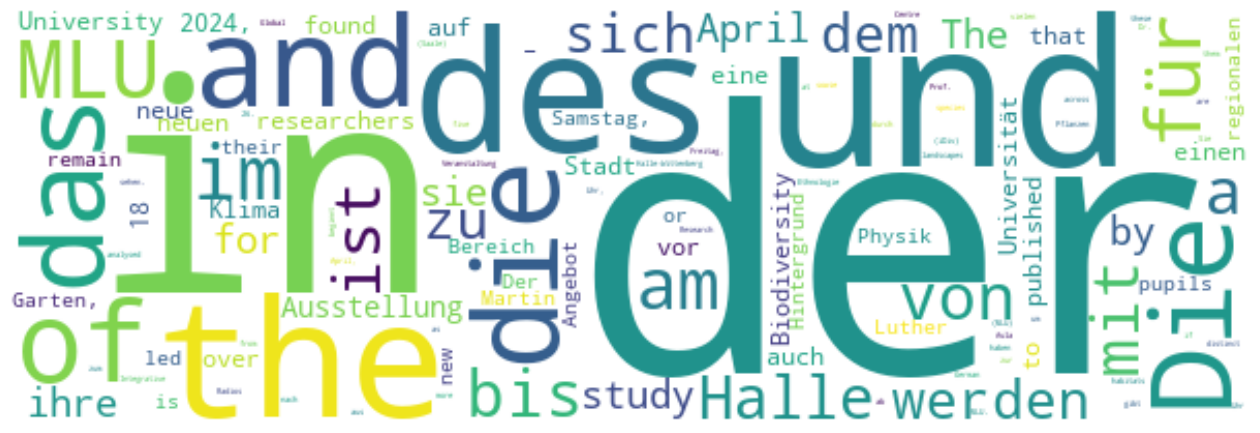

In [98]:
# Counts the frequency of each word in 'raw_text' (note the split function to separate words)
raw_word_frequency = collections.Counter(raw_text.split())
print(raw_word_frequency)

# Generates a Word Cloud image from the word frequencies
wc = WordCloud(width=600, height=200, max_words=200, background_color='white').generate_from_frequencies(raw_word_frequency)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Pre-processing

Pre-processing in NLP refers to the preliminary steps involved in transforming raw data (text) into an understandable format. Effective machine learning models are built specifically on well-structured data. In other words, whenever we receive any form of raw data, it's not always in the state we need it to be in. In fact, raw data often has a lot of noise such as punctuation, special characters, numbers, etc., which can often be irrelevant when processing text data.

These are common steps in pre-processing:

* **Tokenization**: It is the process of splitting the text into individual words or tokens.
* **Lowercasing**: All the text is converted into lowercase to ensure the algorithm does not treat the same words in different cases as different.
* **Stop words removal**: This process involves **removing common language** articles like 'a', 'an', 'in', 'the' etc. as they do not contain useful information for NLP tasks.
* **Punctuation removal**: Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters.
* **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their **word stem, base or root form**. For example, the stem of the words 'jumping', 'jumps', 'jumped' is 'jump'.
* **Lemmatization**: Similar to stemming, but lemmatization provides the **base forms of words** known as lemma. Unlike stemming, it converts words to their actual root. For example, 'better' would be converted to 'good'.

### Regular expression (**regex**)

Part of (almost) every textual analysis: [regular expressions (regex)](https://en.wikipedia.org/wiki/Regular_expression) are a powerful tool that is used for **pattern matching** and **manipulation of text strings**. They provide a flexible and concise means to match, locate, and manage text.

A regular expression is a sequence of characters that forms a **search pattern**. This pattern can be used in a search operation to **find a match or to replace** text. The pattern can be a simple string, or it can be a more complex pattern that uses special characters to find a broader range of matches.

Here are some of the common special characters and sequences used in regular expressions:

* '.': Matches any single character except newline
* '*': Matches zero or more occurrences of the preceding character or group
* '+': Matches one or more occurrences of the preceding character or group
* '?': Matches zero or one occurrence of the preceding character or group
* '^': Matches the start of a line
* '$': Matches the end of a line
* '[abc]': Matches any character a, b, or c
* '(abc)': Matches the group of characters 'abc'
* '\d': Matches any digit, equivalent to [0-9]
* '\D': Matches any non-digit character
* '\w': Matches any alphanumeric character or underscore, equivalent to [A-Za-z0-9_]
* '\W': Matches any non-alphanumeric character
* '\s': Matches any whitespace character
* '\S': Matches any non-whitespace character

These are just a few examples, and different languages and tools can have additional features or syntax in their regular expression engines.

A very helpful tool for designing regular expressions is [https://regex101.com/](https://regex101.com/)

In [99]:
# Regex to remove all non-alphabetical characters except German special chars and "-"
processed_text = re.sub('[^a-zA-ZäöüÄÖÜß-]', ' ', raw_text)
# Convert all characters to lowercase 
processed_text = processed_text.lower()
# Split the text into individual words (you could also use 'nltk.tokenize.word_tokenize' or lemming/stemming)
processed_text = processed_text.split()

# Please note that news articles here are in English and German, so we combine both stop words lists
stop_words = set(nltk.corpus.stopwords.words('german') + nltk.corpus.stopwords.words('english'))
# Remove stop words from the processed text
processed_text = [word for word in processed_text if word not in stop_words]

print(processed_text)

['mlu', 'beteiligt', 'museumsnacht', 'halle-leipzig', 'samstag', 'mai', 'uhr', 'jahr', 'laden', 'archäologische', 'museum', 'botanische', 'garten', 'geiseltalmuseum', 'geologische', 'garten', 'zentrale', 'kustodie', 'zoologische', 'sammlung', 'mlu', 'interessierte', 'nächtlichen', 'streifzug', 'wintersemester', 'startet', 'institut', 'physik', 'mlu', 'neue', 'bachelor-studiengang', 'physik', 'nanotechnologie', 'direkten', 'berufseinstieg', 'qualifiziert', 'neue', 'angebot', 'entsteht', 'hintergrund', 'european', 'chips', 'act', 'vorsieht', 'bereich', 'halbleitertechnologie', 'große', 'produktionskapazitäten', 'deutschland', 'sachsen-anhalt', 'aufzubauen', 'studiengang', 'daher', 'regionalen', 'chipfertigung', 'angegliederten', 'industrie', 'verknüpft', 'umfassend', 'informiert', 'angebot', 'studieninteressierte', 'rahmen', 'studieninfotags', 'physik', 'samstag', 'april', 'intelligent', 'tutoring', 'systems', 'math', 'problems', 'helped', 'pupils', 'remain', 'even', 'increase', 'perform

Counter({'mlu': 14, 'april': 6, 'halle': 6, 'uhr': 5, 'study': 4, 'biodiversity': 4, 'klima': 4, 'ausstellung': 4, 'physik': 3, 'neue': 3, 'led': 3, 'university': 3, 'researchers': 3, 'found': 3, 'published': 3, 'research': 3, 'global': 3, 'universität': 3, 'stadt': 3, 'neuen': 3, 'samstag': 2, 'garten': 2, 'angebot': 2, 'hintergrund': 2, 'bereich': 2, 'große': 2, 'deutschland': 2, 'regionalen': 2, 'pupils': 2, 'remain': 2, 'new': 2, 'martin': 2, 'luther': 2, 'halle-wittenberg': 2, 'analysed': 2, 'five': 2, 'years': 2, 'journal': 2, 'species': 2, 'distinct': 2, 'across': 2, 'landscapes': 2, 'german': 2, 'centre': 2, 'integrative': 2, 'idiv': 2, 'habitats': 2, 'freitag': 2, 'ab': 2, 'aula': 2, 'löwengebäudes': 2, 'zudem': 2, 'sowie': 2, 'saale': 2, 'prof': 2, 'dr': 2, 'aktuelle': 2, 'mitteldeutschen': 2, 'veranstaltung': 2, 'beginnt': 2, 'pflanzen': 2, 'europa': 2, 'zeigt': 2, 'vielen': 2, 'ethnologie': 2, 'gibt': 2, 'sehen': 2, 'entwicklung': 2, 'radios': 2, 'beteiligt': 1, 'museumsnac

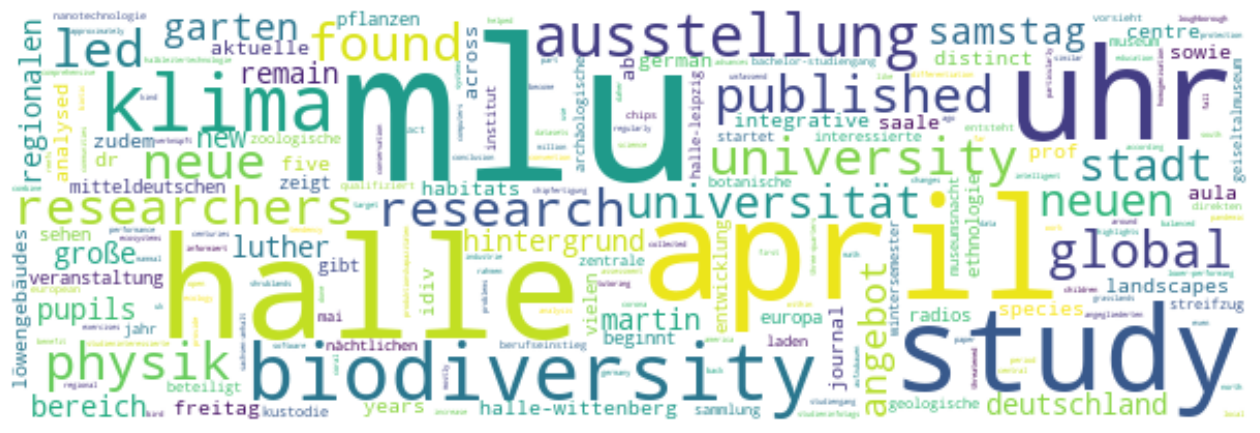

In [100]:
# Counts the frequency of each word in 'processed_text'
word_frequency = collections.Counter(processed_text)
print(word_frequency)

# Generates a Word Cloud image from the word frequencies
wc = WordCloud(width=600, height=200, max_words=200, background_color='white').generate_from_frequencies(word_frequency)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Natural language processing (NLP)

How to squeeze textual data into machine learning methods?

## Bag of words

In [101]:
# Text input
malory = ["Do you want ants?",
          "Because that's how you get ants."]

# All unique tokens from the text input (here words, could be n-grams)
feature_names = ['ants', 'because', 'do', 'get', 'how', 'that', 'want', 'you']

# The feature matrix containing the frequency of each token in the text input
feature_matrix = np.array([[1, 0, 1, 0, 0, 0, 1, 1],
                           [1, 1, 0, 1, 1, 1, 0, 1]])

display(pd.DataFrame(feature_matrix, columns=feature_names, index=malory))

,ants,because,do,get,how,that,want,you
Do you want ants?,1,0,1,0,0,0,1,1
Because that's how you get ants.,1,1,0,1,1,1,0,1


Given such a feature matrix representation, there are a number of methods, such as [Taddy, M. (2013). "Multinomial inverse regression for text analysis." *Journal of the American Statistical Association*, 108(503), 755-770](https://www.tandfonline.com/doi/pdf/10.1080/01621459.2012.734168?casa_token=JCsl7y3uA0YAAAAA:TWGjlwzreKbZsoVD9_ETwBds-41tbPQQNGYsgqKbdNnMGmrENrxS3DD67d-Tkpfvgbes3BgAZJqM), which allow you to analyze textual data. Think of this conceptually like a simple linear regression, where the **token counts are explanatory variables**. Obviously, the model is heavily over-specified, given the high-dimensional feature matrix. Thus, MNIR is actually a **dimension reduction** technique, much like Lasso regression.


### Sentiment analysis

Sentiment analysis, also referred to as **opinion mining**, is a subfield of Natural Language Processing (NLP) that aims to identify and extract subjective information from text sources. The primary objective is to determine the sentiment expressed in a piece of text, which could be positive, negative, or neutral. 

We typically find **lexicon or glossary based approaches** to sentiment analysis. A lexicon-based approach to sentiment analysis is different from machine learning-based approaches. Machine learning models learn from labelled data, extracting patterns from this data to predict sentiment in unseen data. A sentiment lexicon, such as VADER, however, already has **sentiment scores for each word**, and applies rules to these scores to compute the sentiment of a whole sentence or a text.

[VADER (Valence Aware Dictionary and Sentiment Reasoner)](https://ojs.aaai.org/index.php/icwsm/article/view/14550) is a lexicon and rule-based sentiment analysis tool that is particularly attuned to sentiment expressed in social media contexts. It's used in the field of Natural Language Processing (NLP) to quantify the sentiment of a piece of text, such as a tweet or a review. A similar example is the **non-answer glossary** that will be introduced further below, available at: https://econlinguistics.org/glossary.txt


See:
* https://www.nltk.org/api/nltk.sentiment.vader.html
* https://www.kaggle.com/datasets/nltkdata/vader-lexicon

In [102]:
# Importing necessary libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

def analyze_sentiment(article_text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(article_text)
    return sentiment


# Positive text
positive_text = "The product is wonderful and the service has been outstanding."
print(f"Positive text polarity: {analyze_sentiment(positive_text)}")

# Negative text
negative_text = "The firm reported a disappointing quarter, with revenues falling short of expectations."
print(f"Negative text polarity: {analyze_sentiment(negative_text)}")

# Neutral text
neutral_text = "The Federal Reserve announced a new interest rate of 0.75%."
print(f"Neutral text polarity: {analyze_sentiment(neutral_text)}")

# Sentiment used in MLU news (note that a mixture of German and English could be a problem here)
print(f"MLU news sentiment: {analyze_sentiment(' '.join(processed_text))}")

Positive text polarity: {'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compound': 0.8271}
Negative text polarity: {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.5859}
Neutral text polarity: {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'compound': 0.4588}
MLU news sentiment: {'neg': 0.024, 'neu': 0.944, 'pos': 0.032, 'compound': 0.5945}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### A machine learning approach to measuring **non-answers**

[Barth, A., Mansouri, S., & Woebbeking, F. (2023). “Let Me Get Back to You” — A Machine Learning Approach to Measuring NonAnswers. Management Science, 69(10), 6333-6348.](https://pubsonline.informs.org/doi/pdf/10.1287/mnsc.2022.4597?casa_token=a-68hu3F_iQAAAAA:lqkseC9douDRH7veWc3SlZLjcqSs2npOAc3msF0ikt2zifL3TkyDOW6__xaiUup5MoB4THWpTx8)

![wordcloud.png](figures/pos_wc-.png)

## Word embedding

[Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. Advances in Neural Information Processing Systems, 26.](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)

Word embedding is a technique in natural language processing that involves **mapping words into dense, continuous vector representations**, capturing their semantic and syntactic meanings. For example, the word "apple" might have the following embedding:
$$
\vec{v}_\text{apple} = [0.12, -0.34, 0.56, 0.78, -0.01, 0.45, -0.23, 0.67, 0.89, -0.05].
$$

These representations are generated using **unsupervised learning** methods, as they do not require manually labeled data but rely on patterns of word usage within **large text corpora**. Models like [Word2Vec](https://www.tensorflow.org/text/tutorials/word2vec), [GloVe](https://nlp.stanford.edu/projects/glove/), and [FastText](https://fasttext.cc/) recognize relationships between words based on their **contextual co-occurrence** and transform this information into numerical vectors. This approach enables the **encoding of complex linguistic relationships**, improving the performance of tasks such as sentiment analysis and machine translation.

Please note that not only tokens (words) but also entire texts can be represented by vector embeddings. For instance, embeddings used in GPT-3 models can range up to a length of $12,288$.




Example: t-distributed Stochastic Neighbor Embedding (TSNE)

![logo.png](figures/tsne.png)

In [111]:
# Simplified word embeddings for cities and countries
word_embeddings = {
    "Paris": np.array([0.8, 0.2, 0.1]),
    "France": np.array([0.7, 0.2, 0.2]),
    "Berlin": np.array([0.6, 0.4, 0.2]),
    "Germany": np.array([0.6, 0.3, 0.3]),
    "Rome": np.array([0.5, 0.6, 0.2]),
    "Italy": np.array([0.5, 0.5, 0.3])
}

# Function to calculate cosine similarity between two vectors
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

print(f"Paris|France: {cosine_similarity(word_embeddings['Paris'], word_embeddings['France']):.2f}")
print(f"Paris|Berlin: {cosine_similarity(word_embeddings['Paris'], word_embeddings['Berlin']):.2f}")
print(f"Paris|Italy:  {cosine_similarity(word_embeddings['Paris'], word_embeddings['Italy']):.2f}")

Paris|France: 0.99
Paris|Berlin: 0.93
Paris|Italy:  0.83


In [104]:
# Vector arithmetic: Berlin - Germany + France
result_vector = word_embeddings["Berlin"] - word_embeddings["Germany"] + word_embeddings["France"]

# Find the closest word to the resulting vector
closest_city = None
max_similarity = -1
for word in ["Paris", "Rome", "Italy"]: 
    similarity = cosine_similarity(result_vector, word_embeddings[word])
    if similarity > max_similarity:
        max_similarity = similarity
        closest_word = word

print(f"'Berlin' - 'Germany' + 'France' = '{closest_word}' ({similarity:.2f})")

'Berlin' - 'Germany' + 'France' = 'Paris' (0.90)


## Transformer architecture

[Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

![logo.png](figures/moore.PNG)

In [105]:
word_embeddings = {
    "Paris": np.array([0.8, 0.2, 0.1]),
    "France": np.array([0.7, 0.3, 0.2]),
    "Berlin": np.array([0.6, 0.1, 0.2]),
    "Germany": np.array([0.6, 0.4, 0.3]),
    "Rome": np.array([0.5, 0.2, 0.2]),
    "Italy": np.array([0.5, 0.5, 0.3])
    }

# This code is just illustrative ... focus on the steps, not the code!
def transformer_encoder(word_embeddings):
    # Step 1: Input Embedding
    word_embeddings = word_embeddings

    # Step 2: Positional Encoding
    positional_embeddings = {word: vec + 0.1 for word, vec in word_embeddings.items()}

    # Step 3: Attention
    attention_sum = sum(positional_embeddings.values())
    attention_output = {word: vec * attention_sum for word, vec in positional_embeddings.items()}

    # Step 4: Feed-Forward Network
    feed_forward_output = {word: vec + np.array([0.3, 0.3, 0.3]) for word, vec in attention_output.items()}

    return feed_forward_output


# Process the embeddings through the transformer encoder
transformed_embeddings = transformer_encoder(word_embeddings)
print(transformed_embeddings)

{'Paris': array([4.17, 0.99, 0.68]), 'France': array([3.74, 1.22, 0.87]), 'Berlin': array([3.31, 0.76, 0.87]), 'Germany': array([3.31, 1.45, 1.06]), 'Rome': array([2.88, 0.99, 0.87]), 'Italy': array([2.88, 1.68, 1.06])}


**Positional Encoding**: This step modifies the original word embeddings by adding a positional value to each element. In real transformers, positional encoding is crucial because it provides information about the position of each word in the sequence. Our simple version just adds 0.1 to every element, but real models use more complex functions for positional encoding.

**Attention**: The self-attention mechanism in transformers allows each position in the encoder to consider every other position in the input sequence when computing its representation. In our example, we simulate self-attention by summing all the positional embeddings and then multiplying each embedding with this sum. This is a vast simplification and doesn't truly represent the selective attention mechanism used in real transformers.

**Feed-Forward Network**: In an actual transformer, each position's output from the self-attention layer is processed by a feed-forward neural network. This network consists of linear transformations and non-linear activations, allowing the model to learn complex transformations of the data. In our example, we simplify this by adding a fixed array [0.3, 0.3, 0.3] to each embedding vector, simulating a very basic transformation.

In [106]:
def classify_city_country(transformed_embeddings):
    classification = {}
    for word, vec in transformed_embeddings.items():
        # Classification rule: if the second element is greater than 1.2, classify as Country, else as City
        classification[word] = "Country" if vec[1] > 1.2 else "City"
    return classification


# Classify each word as City or Country
classification = classify_city_country(transformed_embeddings)

# Displaying the classification results
for word, category in classification.items():
    print(f"{word} is a {category}")

Paris is a City
France is a Country
Berlin is a City
Germany is a Country
Rome is a City
Italy is a Country


### Fine tuning

Large Language Models (LLMs) are often incredibly vast, making training one from scratch a time-consuming and resource-intensive process. Instead, **fine-tuning** involves taking an existing, **pre-trained model** and adjusting it to excel at a specific task or dataset. This adaptation is accomplished through a supervised learning process that involves **updating the model's weights**. By leveraging fine-tuning, developers can significantly reduce the computational burden while achieving more focused, accurate results. For tools, resources, and examples on fine-tuning, visit the Hugging Face platform: https://huggingface.co/.

## ChatGPT API

The OpenAI API allows developers to **integrate advanced AI models like GPT-4** into their applications for tasks like text generation and summarization. To get started, check out the [API Reference](https://platform.openai.com/docs/guides) for detailed guides and examples, or the [Quickstart Tutorial](https://platform.openai.com/docs/quickstart) to quickly set up your first project. You can find cost information for different models on the [API Pricing page](https://platform.openai.com/pricing).

Before we get started, let us introduce a way to **protect your password or api key**. Obviously, you would never want to commit sensitive information to a Git repository. In order to protect my own OpenAI API key, I have stored it in a file called **local.ini**, which I have set to be ignored by Git.

The local.ini file content looks like this:

```Bash
# This is the key that we are after
[openai]
key = geheim123!

# This is just an additional exmaple
[deribit]
account_name = some name
password = geheim123!
```

We can utilize Python's [configparser](https://docs.python.org/3/library/configparser.html) to manage .ini files. By the way, these files are not encrypted on your local machine!

In [107]:
# Use your password to log in here ...
config = configparser.ConfigParser()
config.read('local.ini')

# Extract the password
openai.api_key = config['openai']['key'].strip()

#returns a list of all OpenAI models
models = openai.models.list()
print(f"OpenAI currently offers {len(models.data)} models, e.g.:")
display(models.data[0::5])

OpenAI currently offers 30 models, e.g.:


[Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'),
 Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'),
 Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'),
 Model(id='gpt-4-vision-preview', created=1698894917, object='model', owned_by='system'),
 Model(id='gpt-3.5-turbo-0301', created=1677649963, object='model', owned_by='openai'),
 Model(id='text-embedding-ada-002', created=1671217299, object='model', owned_by='openai-internal')]

### Prompt Engineering

Prompt engineering is the practice of crafting effective inputs to guide AI models, like GPT, in generating accurate, relevant, and coherent responses. It involves thoughtfully structuring the prompts to clarify the intention and context, helping the model comprehend what is being asked and respond appropriately.

Key Considerations:

- **Clarity and Specificity**  
  - Use clear and specific language to reduce ambiguity.
  - Provide relevant context or background information.

- **Prompt Length**  
  - Balance between providing sufficient detail and keeping the prompt concise.

- **Task Framing**  
  - Frame the task in a way that aligns with the intended outcome (e.g., summary, explanation, or brainstorming).

- **Examples and Constraints**  
  - Provide examples or constraints when necessary to guide the response format or style.

- **Iterative Refinement**  
  - Test, analyze, and refine prompts to improve output quality.

- **Instruction Structure**  
  - Organize instructions logically with bullet points, numbered lists, or separate paragraphs.

- **Output Format**  
  - Specify the desired format, such as bullet points, tables, lists, **JSON**, or paragraphs.


In [112]:
# Creating the prompt
messages = [{"role": "system", "content": 
    "You are a helpful assistant."}]
messages.append({"role": "user", "content": 
    "Classify into two categories, namely, 'City' and 'Country'"})
messages.append({"role": "user", "content": 
    "Classify this: Germany, Paris, France, Berlin, Rome, Italy"})
messages.append({"role": "user", "content": 
    "The output should be in JSON format."})

### API call

In [109]:
# Send prompt to API and retrieve results
completion = openai.chat.completions.create(
                model="gpt-4", temperature=0.0, seed=2024, messages=messages
            )
print(completion.choices[0].message.content)

{
  "City": ["Paris", "Berlin", "Rome"],
  "Country": ["Germany", "France", "Italy"]
}


API parameters https://platform.openai.com/docs/api-reference
* temperature: "What sampling temperature to use, between 0 and 2. Lower values will make it more focused and deterministic."
* seed: "This feature is in Beta. If specified, **our system will make a best effort to sample deterministically**, such that repeated requests with the same seed and parameters should return the same result."

## Retrieval-Augmented Generation (RAG) 

Retrieval-Augmented Generation (RAG) is a method where a **large language model combines its internal knowledge with relevant external information** from a retriever system. This retriever pulls relevant documents or data from a larger corpus, and the generator integrates this information to create a more accurate and up-to-date response.

Fo example: A customer support chatbot uses a RAG system. When asked a complex question about a software feature, the bot retrieves recent support documentation and then uses the language model to provide a detailed, accurate, and context-aware answer that integrates both its training knowledge and current documentation.


If you are interested in exploring this further, have a look at our RAG platform: [https://github.com/Analystics-AI/Guideline_RAG](https://github.com/Analystics-AI/Guideline_RAG)
